# Principle Components Regression 

This short programming assignment will show how principal components can be used as a dimensionality reduction preprocessing step.

You will begin by treating principal component regression as a linear model with PCA transformations in the preprocessing. But using the tidymodels framework then this is still mostly one model. Once again you begin by loading the appopriate packages and loading up the training and testing sets.

In [1]:
library(tidymodels)
library(ISLR2)
Hitters <- as_tibble(Hitters) %>%
  filter(!is.na(Salary))

Hitters_split <- initial_split(Hitters, strata = "Salary")

Hitters_train <- training(Hitters_split)
Hitters_test <- testing(Hitters_split)

Hitters_fold <- vfold_cv(Hitters_train, v = 10)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ recipes      1.0.9
✔ dials        1.2.0     ✔ rsample      1.2.0
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.4.4     ✔ tidyr        1.3.1
✔ infer        1.0.6     ✔ tune         1.1.2
✔ modeldata    1.3.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.3.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/



You now set up the following specifications 

In [2]:
lm_spec <- 
  linear_reg() %>% 
  set_mode("regression") %>% 
  set_engine("lm")

The preprocessing recipe will look like the recipe you saw in the ridge and lasso sections. The main difference is that you end the recipe with `step_pca()` which will perform `principal component analysis` on all the predictors, and return the components that explain `threshold` percent of the variance. You have set `threshold = tune()` so you can treat the threshold as a hyperparameter to be tuned. By using workflows and tune together can be tune parameters in the preprocessing as well as parameters in the models.

In [3]:
pca_recipe <- 
  recipe(formula = Salary ~ ., data = Hitters_train) %>% 
  step_novel(all_nominal_predictors()) %>% 
  step_dummy(all_nominal_predictors()) %>% 
  step_zv(all_predictors()) %>% 
  step_normalize(all_predictors()) %>%
  step_pca(all_predictors(), threshold = tune())

pca_workflow <- 
  workflow() %>% 
  add_recipe(pca_recipe) %>% 
  add_model(lm_spec)

Now you will create a smaller grid for threshold and we don’t need to modify the range since [0, 1] is an acceptable range. Have your outpur variable be `threshold_grid`. Use the `grid_regular` function with `10` levels. 

In [4]:
threshold_grid <- grid_regular(threshold(), levels = 10)

And now you will fit using `tune_grid()`. This time you will actually perform 100 fits since you need to fit a model for each value of threshold within each fold. You will use the output variable `tune_res`. Don't forget to use the `pca_workflow` as part of your `tune_grid()`, as well as the `Hitters_fold` and `threshold_grid`. 


In [5]:
# Perform tuning
tune_res <- tune_grid(
  pca_workflow,
  resamples = Hitters_fold,
  grid = threshold_grid
)

# Show tuning results
tune_res_results <- collect_metrics(tune_res)
print(tune_res_results)

# A tibble: 20 × 7
   threshold .metric .estimator    mean     n std_err .config              
       <dbl> <chr>   <chr>        <dbl> <int>   <dbl> <fct>                
 1     0     rmse    standard   357.       10 38.3    Preprocessor01_Model1
 2     0     rsq     standard     0.454    10  0.0658 Preprocessor01_Model1
 3     0.111 rmse    standard   357.       10 38.3    Preprocessor02_Model1
 4     0.111 rsq     standard     0.454    10  0.0658 Preprocessor02_Model1
 5     0.222 rmse    standard   357.       10 38.3    Preprocessor03_Model1
 6     0.222 rsq     standard     0.454    10  0.0658 Preprocessor03_Model1
 7     0.333 rmse    standard   357.       10 38.3    Preprocessor04_Model1
 8     0.333 rsq     standard     0.454    10  0.0658 Preprocessor04_Model1
 9     0.444 rmse    standard   354.       10 39.0    Preprocessor05_Model1
10     0.444 rsq     standard     0.462    10  0.0709 Preprocessor05_Model1
11     0.556 rmse    standard   354.       10 39.0    Preprocessor06_

In [6]:
# Hidden tests


Use the output variable `tune_res` and use the function `auto_plot` to plot your output variable. Your plot should resemble this: 

<div> 
    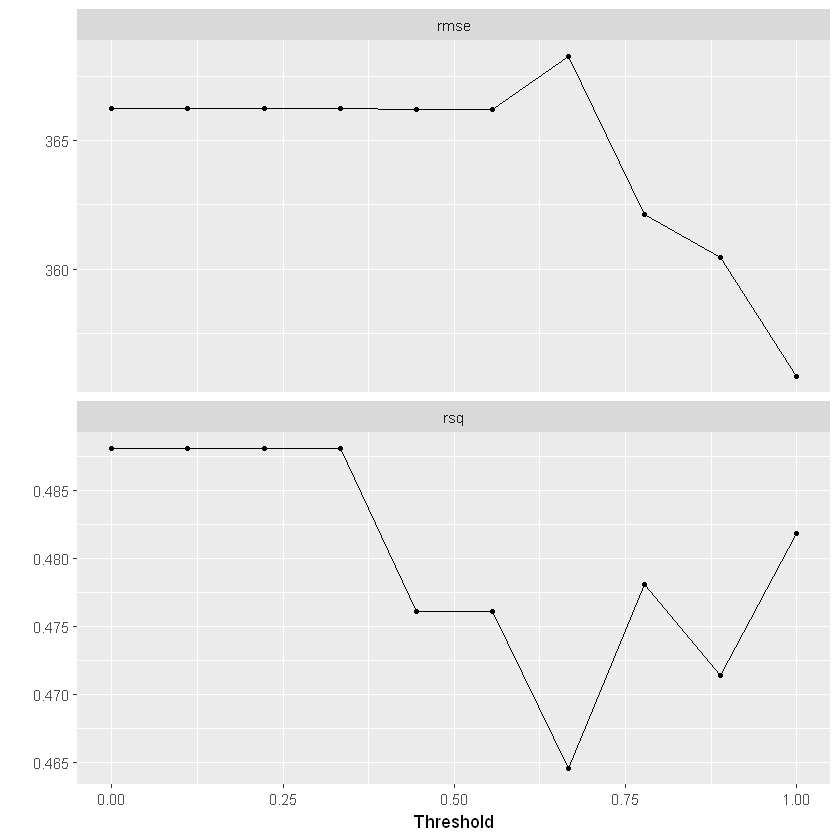
</div>



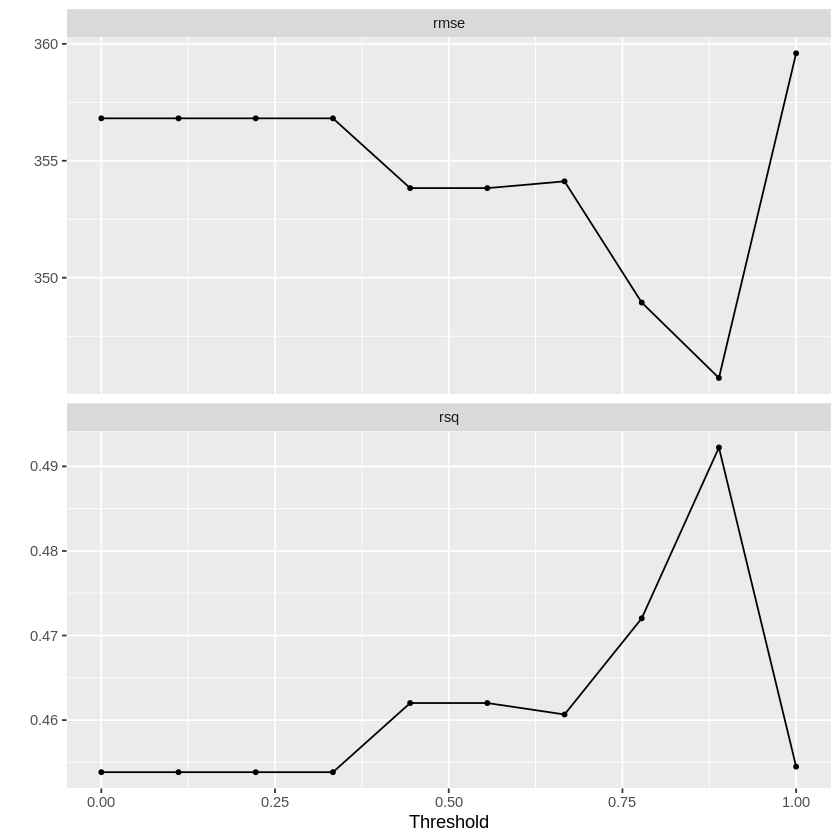

In [7]:
autoplot(tune_res)

If your graphs do not match the graphs above, review your code for `tune_res`.

Select the best model using the `select_best()` function. Have your output variable be `best_threshold`. This time, you should use "rmse" for your metric.

In [8]:
# Get the best threshold value
best_threshold <- select_best(tune_res, "rmse")
print(best_threshold)

# A tibble: 1 × 2
  threshold .config              
      <dbl> <fct>                
1     0.889 Preprocessor09_Model1


Your final step now is going to be to fit the model much like have done a couple of times by now. The workflow is finalized using the value we selected with `select_best()`, and training using the full training data set. Your first output variable should be `pca_final` in conjunction with the function `finalize_workflow()`. Your second output variable should be `pca_final_fit` in conjunction with the function `fit`. 

In [9]:
# Finalize the workflow with the best threshold
pca_final <- finalize_workflow(
  pca_workflow,
  best_threshold
)

# Fit the final model on the full training set
pca_final_fit <- fit(pca_final, data = Hitters_train)

# Output variables
print(pca_final)
print(pca_final_fit)

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
5 Recipe Steps

• step_novel()
• step_dummy()
• step_zv()
• step_normalize()
• step_pca()

── Model ───────────────────────────────────────────────────────────────────────
Linear Regression Model Specification (regression)

Computational engine: lm 

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
5 Recipe Steps

• step_novel()
• step_dummy()
• step_zv()
• step_normalize()
• step_pca()

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          PC1          PC2          PC3          PC4          PC5  
     543.71       105.93  